In [ ]:
# Установка необходимых библиотек в Google Colab
!pip install gensim
!pip install nltk
!pip install matplotlib

  Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (27.9 MB)


In [ ]:
#импортируем библиотеки
import sys
import re, numpy as np
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Настройки отображения
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Загрузка необходимых данных NLTK
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


persuasion = nltk.corpus.gutenberg.sents('austen-persuasion.txt')

# Build the bigram and trigram models
bigram = gensim.models.Phrases(persuasion, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[persuasion], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # удаление стоп-слов после лемматизации
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(persuasion)

# создание словаря
id2word = corpora.Dictionary(data_ready)

corpus = [id2word.doc2bow(text) for text in data_ready]

# инициализация LDA модели
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print("Темы для 'austen-persuasion.txt':")
pprint(lda_model.print_topics())





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Темы для 'austen-persuasion.txt':
[(0,
  '0.026*"elliot" + 0.019*"nothing" + 0.018*"never" + 0.017*"ever" + '
  '0.015*"happy" + 0.015*"last" + 0.012*"happiness" + 0.010*"long" + '
  '0.010*"possible" + 0.009*"met"'),
 (1,
  '0.045*"captain" + 0.043*"mr" + 0.030*"wentworth" + 0.020*"well" + '
  '0.017*"hope" + 0.015*"harville" + 0.014*"sister" + 0.011*"mind" + '
  '0.010*"little" + 0.009*"better"'),
 (2,
  '0.028*"one" + 0.021*"might" + 0.016*"man" + 0.013*"sir" + 0.012*"soon" + '
  '0.012*"every" + 0.012*"walter" + 0.011*"moment" + 0.010*"woman" + '
  '0.009*"enough"'),
 (3,
  '0.041*"anne" + 0.020*"must" + 0.018*"lady" + 0.017*"friend" + 0.015*"said" '
  '+ 0.014*"russell" + 0.013*"feeling" + 0.009*"two" + 0.009*"much" + '
  '0.008*"give"')]


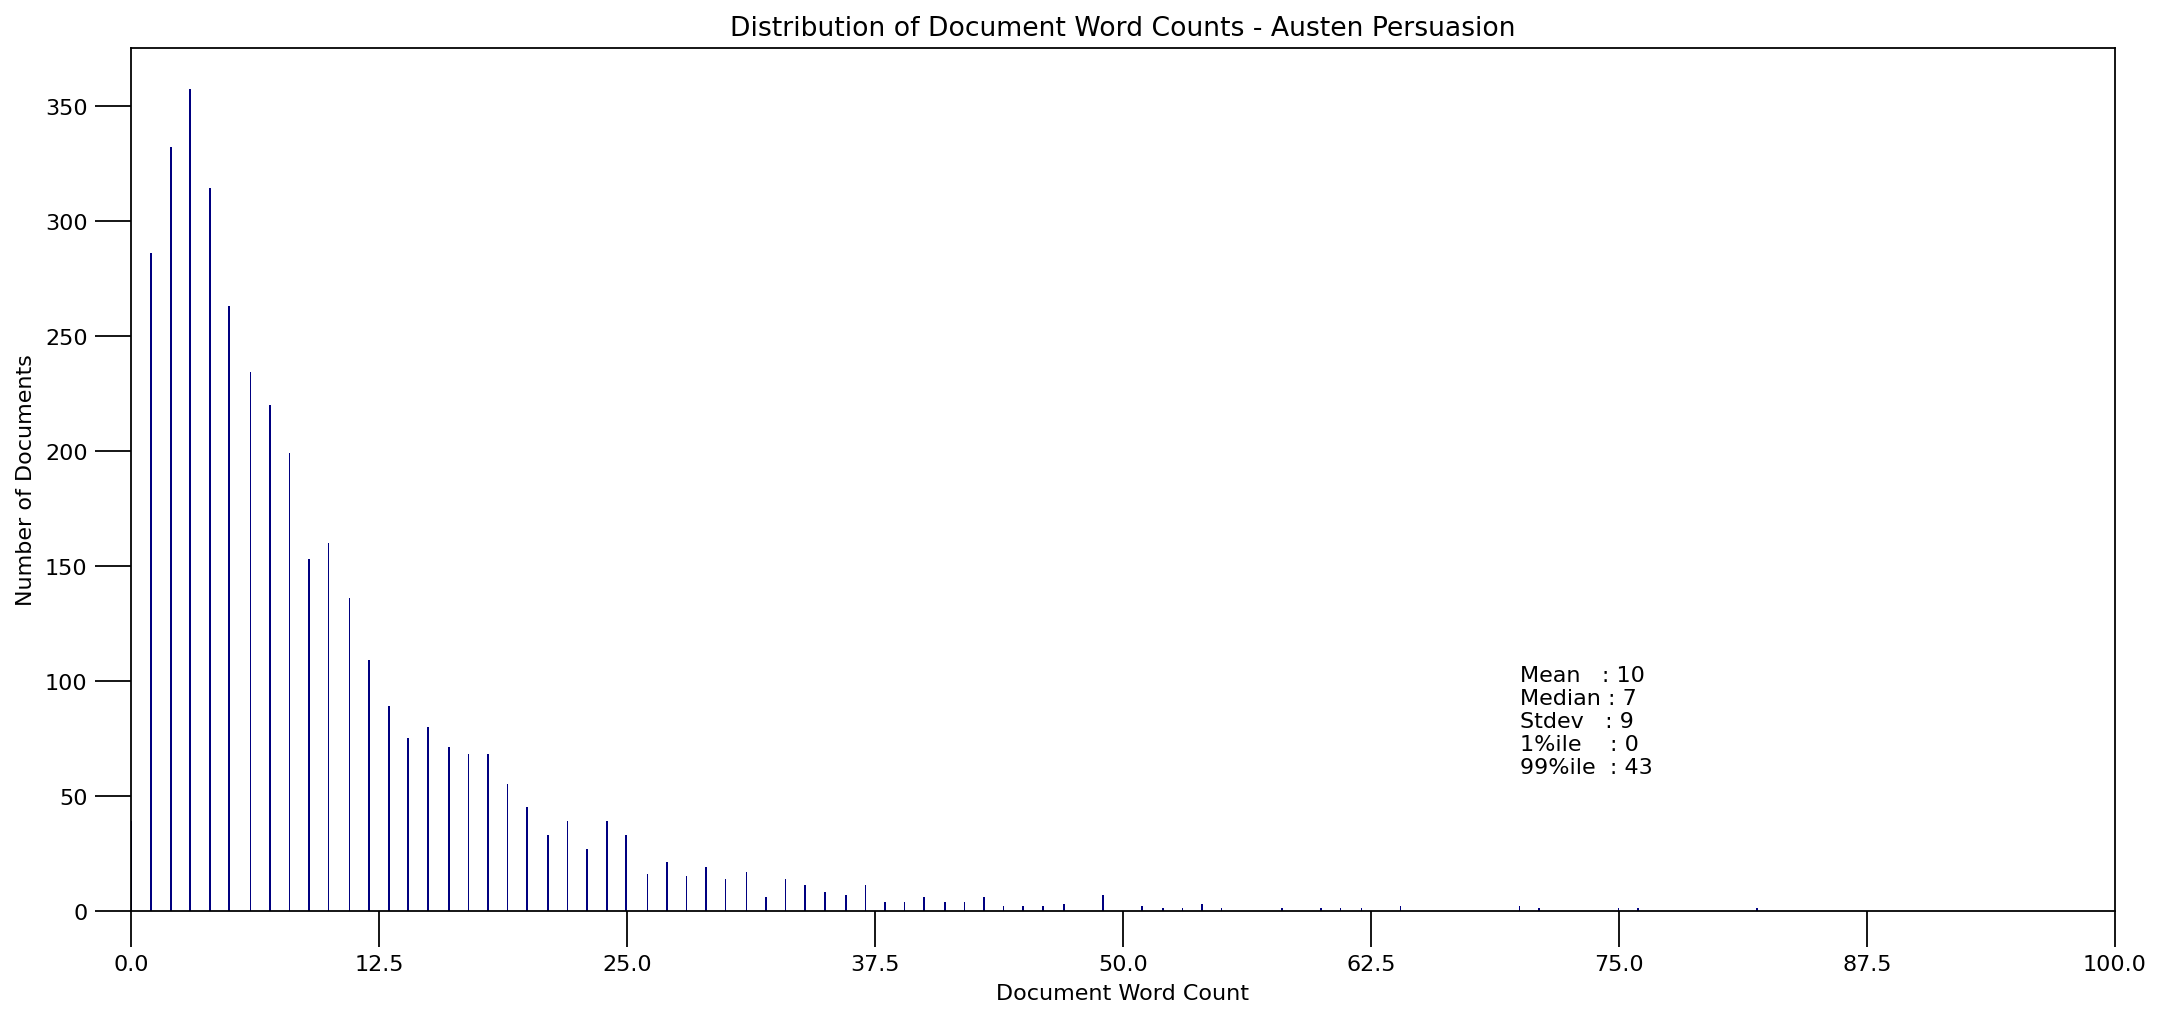

In [ ]:
# Визуализация распределения длины документов
doc_lens = [len(d) for d in data_ready]

plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts - Austen Persuasion')
plt.show()

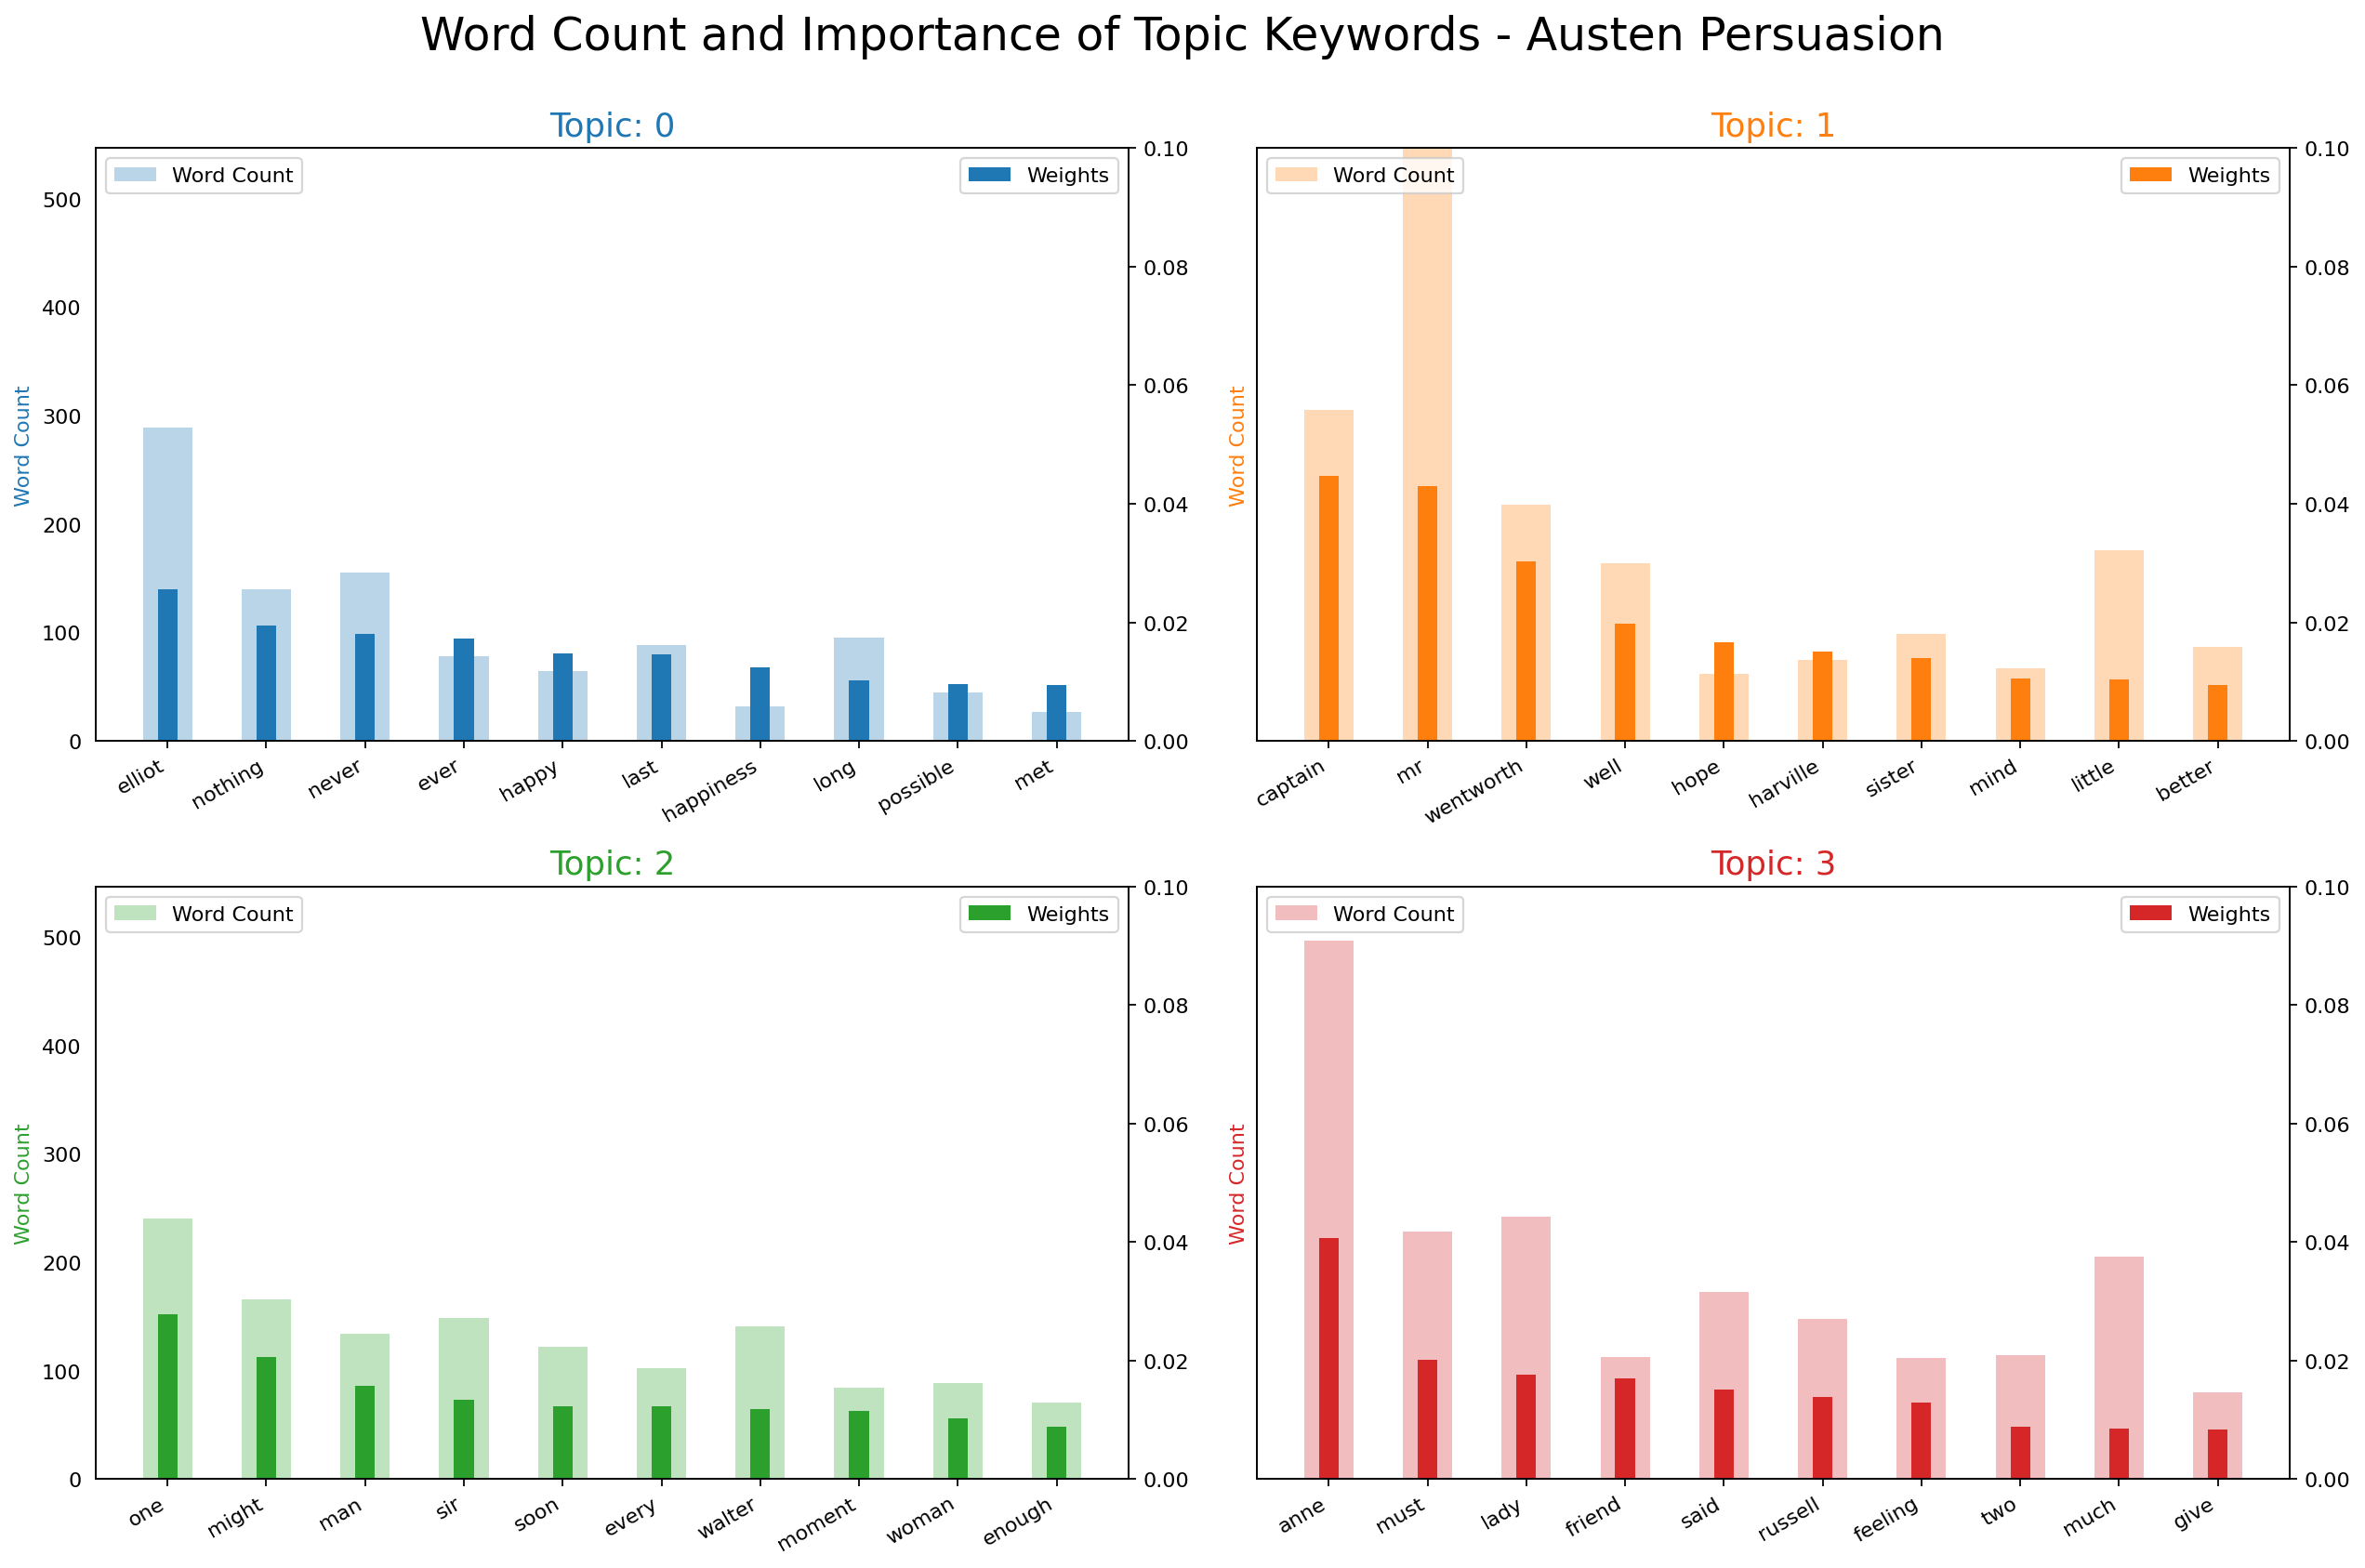

In [ ]:
# Анализ топ-слов в темах
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])


import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    # Создаем DataFrame-like структуру для удобства
    data_dict = {'word': out[i]['word'], 'word_count': out[i]['word_count'], 'importance': out[i]['importance']}

    ax.bar(x=range(len(out[i]['word'])), height=out[i]['word_count'], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x=range(len(out[i]['word'])), height=out[i]['importance'], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, max(out[i]['word_count']) * 1.1)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(range(len(out[i]['word'])))
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords - Austen Persuasion', fontsize=22, y=1.05)
plt.show()



In [ ]:
# Вычисление когерентности модели
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready,
                                   dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Когерентность модели: {coherence_lda:.4f}')

Когерентность модели: 0.3035


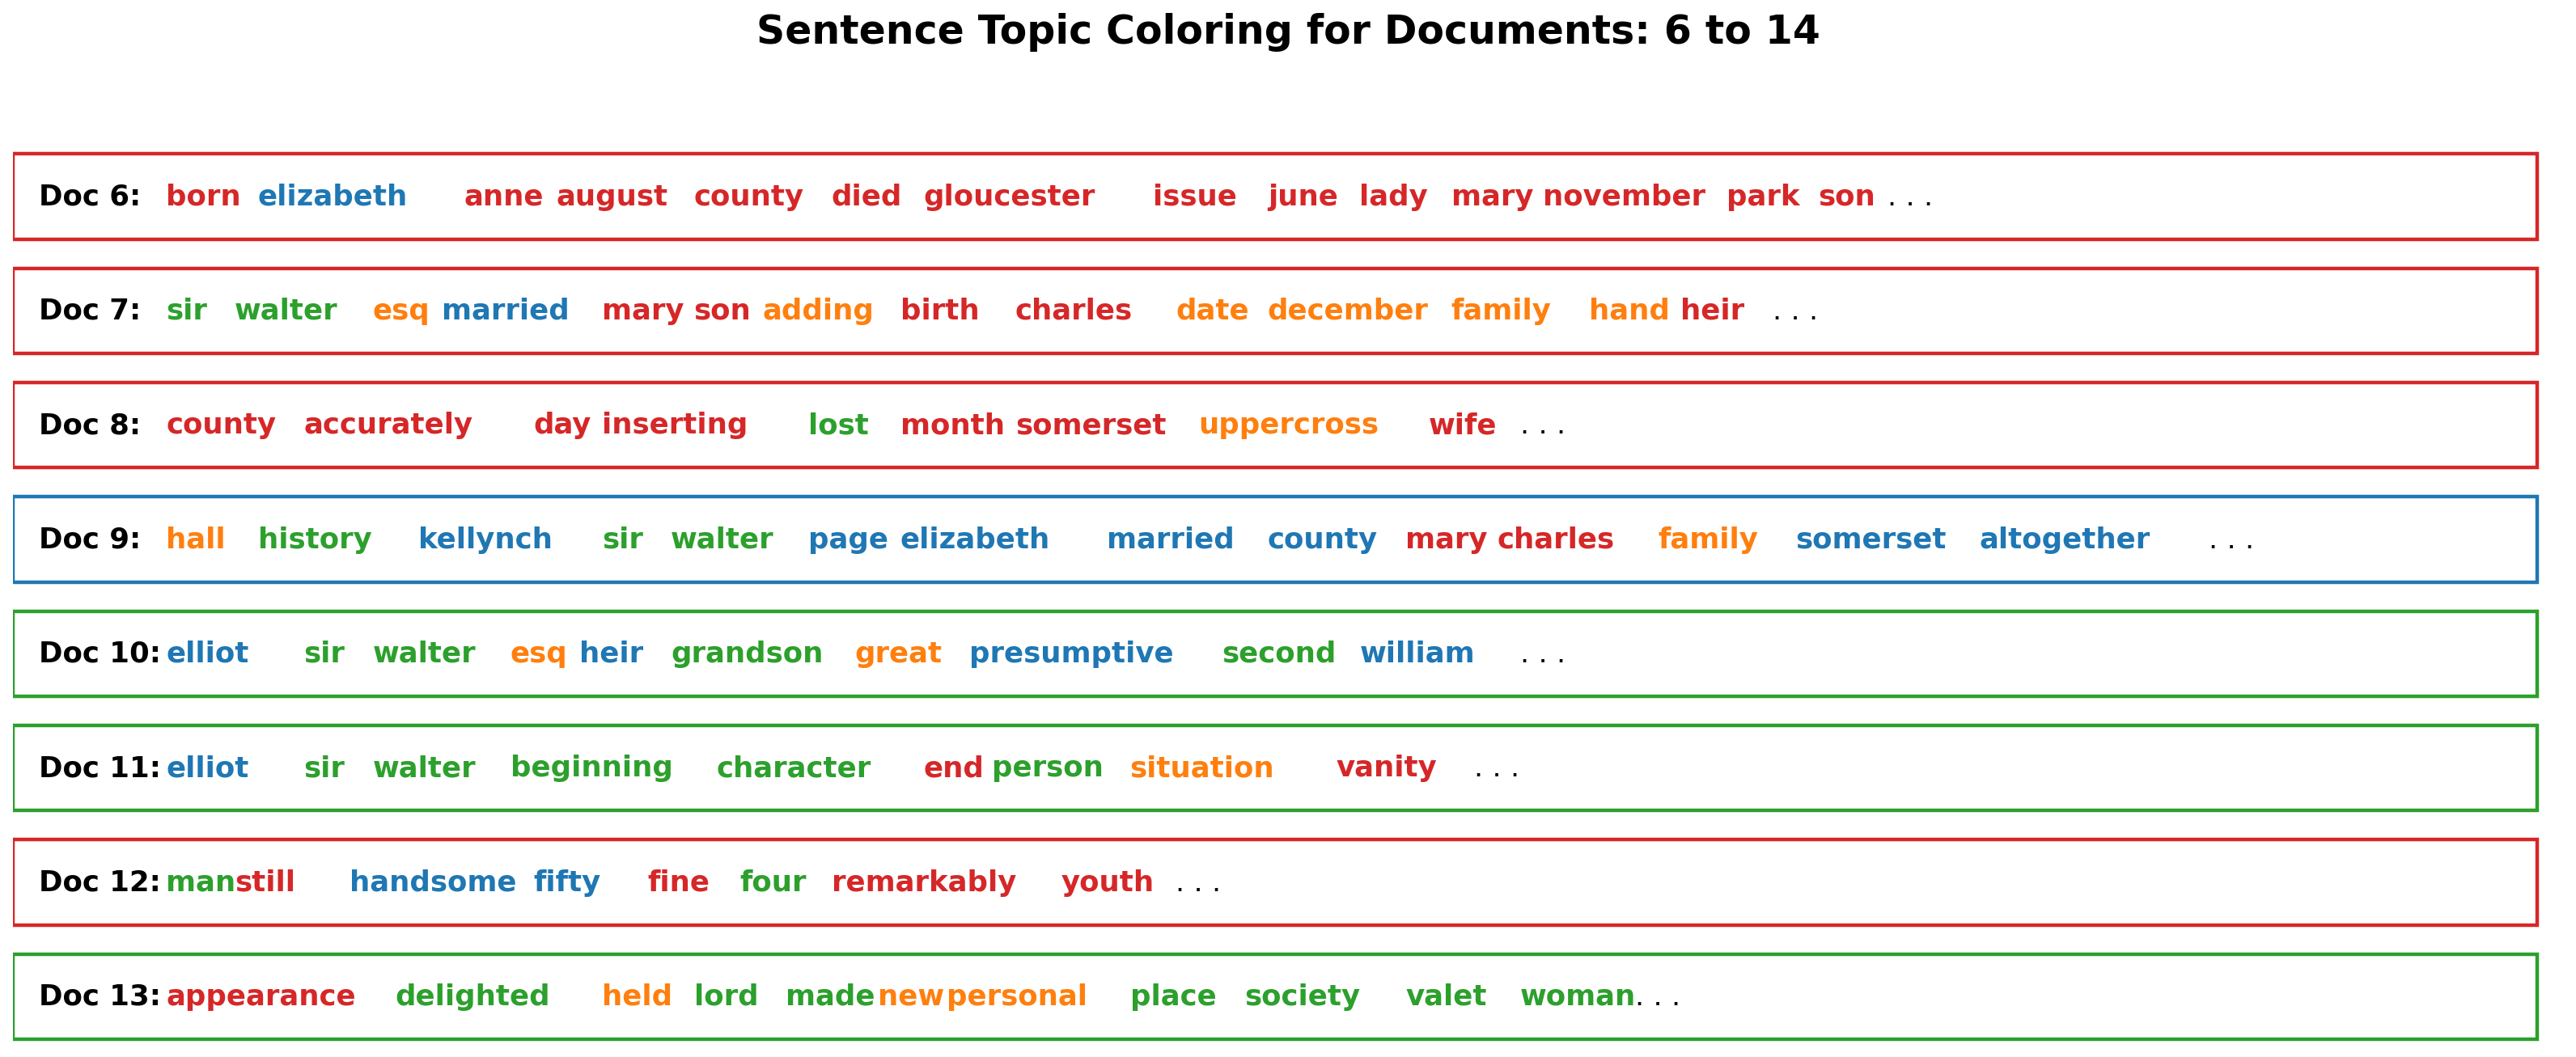

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)


            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения
sentences_chart(start=6, end=15)

##Дополнительная визуализация

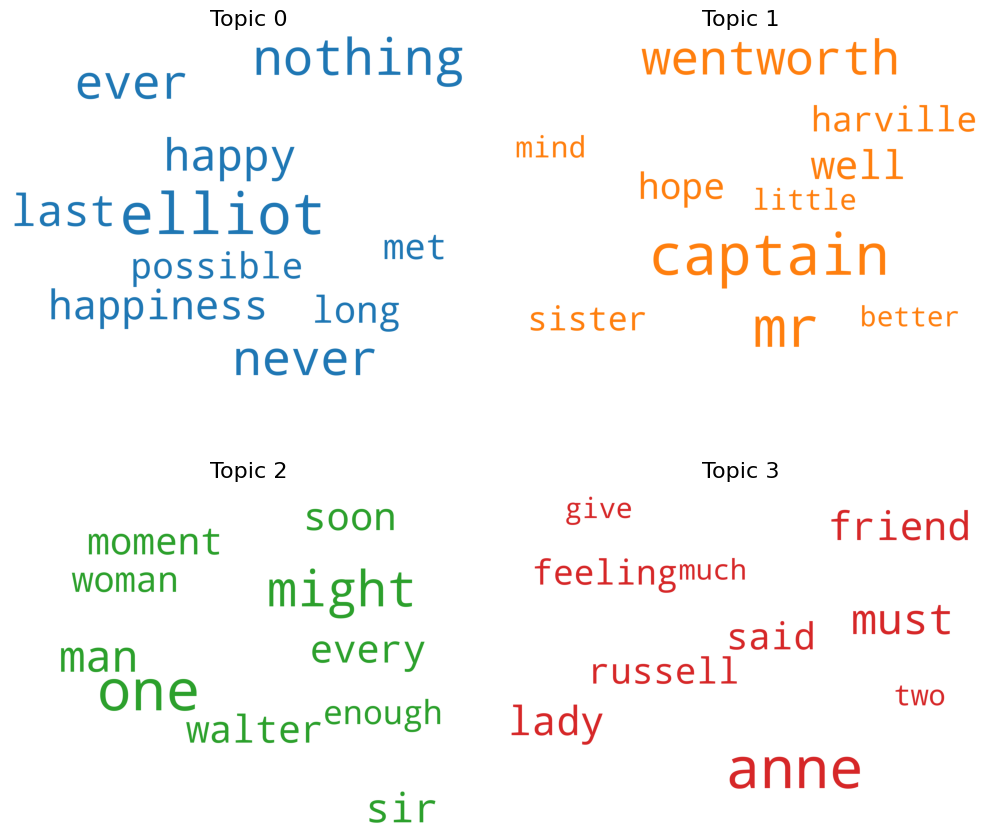

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pandas as pd

topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])


arr = pd.DataFrame(topic_weights).fillna(0).values

arr = arr[np.amax(arr, axis=1) > 0.35]

topic_num = np.argmax(arr, axis=1)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3402 samples in 0.005s...
[t-SNE] Computed neighbors for 3402 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3402
[t-SNE] Computed conditional probabilities for sample 2000 / 3402
[t-SNE] Computed conditional probabilities for sample 3000 / 3402
[t-SNE] Computed conditional probabilities for sample 3402 / 3402
[t-SNE] Mean sigma: 0.000002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.902763
[t-SNE] KL divergence after 1000 iterations: 0.708994


## Вывод

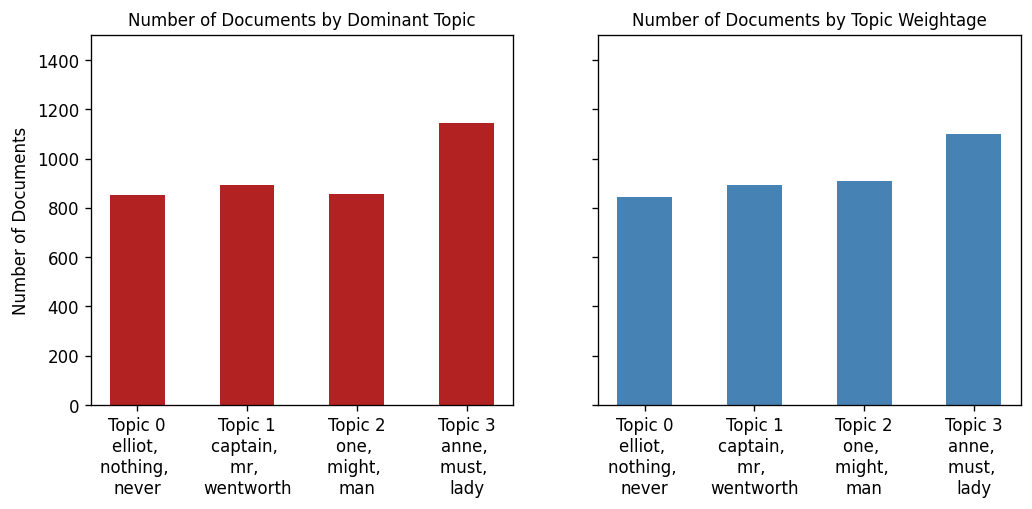

In [ ]:
from matplotlib.ticker import FuncFormatter
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

Модель LDA успешно выявила смысловую структуру романа, демонстрируя высокую эффективность в обработке классического литературного текста. Выделенные тематические кластеры отражают характерные особенности прозы Джейн Остин — внимание к социальным взаимодействиям, психологической мотивации персонажей и нравственным дилеммам. Качество тематического разделения подтверждается семантической согласованностью ключевых слов в каждой теме, что свидетельствует о корректной предобработке текста, включая лемматизацию, фильтрацию стоп-слов и формирование n-грамм.

**Анализ выделенных тем:**

1️) *Тема эмоциональных переживаний*

Ключевые слова (nothing, never, ever, happy, happiness) отражают глубокий эмоциональный подтекст романа, акцентируя внимание на внутренних переживаниях героев, их сомнениях и поиске личного счастья.

2️) *Тема социальных отношений и службе на флоте*

Слова (captain, mr, wentworth, well, hope) подчеркивают важность социального статуса, военно-морской карьеры и межличностных отношений, что соответствует центральному конфликту романа между любовью и социальными условностями.

3️) *Социальная иерархия и гендерные роли*

Лексика (sir, walter, man, woman) раскрывает тему аристократических титулов, семейных традиций и гендерных ожиданий в регентской Англии, что является ключевым для понимания социального контекста романа.

4️) *Тема коммуникация и межличностные связей*

Преобладание слов (anne, lady, said, feeling, friend) указывает на важность диалогов, эмоциональной коммуникации и дружеских отношений в развитии сюжета и раскрытии характеров главных героев.